In [1]:
import numpy as np
import pandas as pd
import torch
from gcn_model import GCNModel
import utilities
from test_model import test_model
import os
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from captum.attr import IntegratedGradients, DeepLift
import seaborn as sns

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq/"
#data_folder = "simulations/splat_0.7_de_rq/"
# get labels
data_path = data_folder + "query_counts.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","singler"]
ref_path = data_folder + "ref_counts.csv"
ref_label_path = data_folder + "ref_labels.csv"
marker_path = data_folder + "markers.txt"
if os.path.exists(data_folder + "preds.csv"):
    all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

# read in dataset
counts = pd.read_csv(data_path, index_col=0)
X, keep_cells, keep_genes, rpca = utilities.preprocess(np.array(counts), scale=False, comps=500)

all_labels = all_labels.loc[keep_cells,:]

_,marker_names = utilities.read_marker_file(marker_path)

all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)

meta_path = data_folder + "query_meta.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y = pd.factorize(metadata['Group'], sort=True)[0]
real_y = real_y[keep_cells]

confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)

train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]


In [3]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)


In [4]:
m = GCNModel("configs/2_40.txt", 2, dropout=0.0)
m.train(dataloader, 150)

Loss in epoch 0 = 25.950359
Loss in epoch 10 = 0.075396
Loss in epoch 20 = 0.018048
Loss in epoch 30 = 0.007761
Loss in epoch 40 = 0.004706
Loss in epoch 50 = 0.002872
Loss in epoch 60 = 0.002204
Loss in epoch 70 = 0.001309
Loss in epoch 80 = 0.000935
Loss in epoch 90 = 0.000925
Loss in epoch 100 = 0.000644
Loss in epoch 110 = 0.000432
Loss in epoch 120 = 0.000394
Loss in epoch 130 = 0.000356
Loss in epoch 140 = 0.000312


In [5]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

(0.955955982208252,
 array([[212,   9,   5,   6],
        [  0, 265,   3,   0],
        [  1,   4, 226,   3],
        [  2,   6,   5, 252]]),
 0.9724972248077393,
 array([[178,   6,   2,   2],
        [  0, 264,   2,   0],
        [  1,   2, 211,   1],
        [  0,   5,   4, 231]]),
 0.7888888716697693,
 array([[34,  3,  3,  4],
        [ 0,  1,  1,  0],
        [ 0,  2, 15,  2],
        [ 2,  1,  1, 21]]))

In [6]:
preds,_ = m.predict(test_dataloader)
final_preds = preds.max(dim=1)[1]

In [7]:
 genes = counts.columns.to_numpy()[keep_genes]

In [8]:
int_df = utilities.run_interpretation(m, X, rpca, final_preds, counts.columns.to_numpy()[keep_genes])

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [9]:
repeated = list(set([x for x in keep_genes if keep_genes.count(x) > 1]))

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [ ]:
int_df.loc[repeated,:]

[Text(0.5, 15.0, 'Cell Type')]

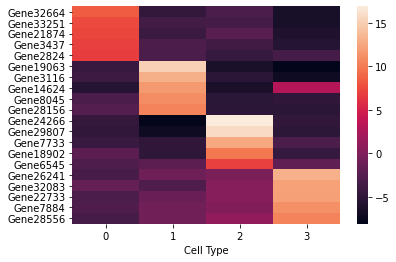

In [10]:
keep_genes = int_df.sort_values(0, ascending=False).head(5).index.tolist()
keep_genes += int_df.sort_values(1, ascending=False).head(5).index.tolist()
keep_genes += int_df.sort_values(2, ascending=False).head(5).index.tolist()
keep_genes += int_df.sort_values(3, ascending=False).head(5).index.tolist()
ax = sns.heatmap(int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [19]:
predictions = final_preds.cpu()
prediction_names = predictions.unique().tolist()
classes = [None]*len(prediction_names)
for i, pred in enumerate(prediction_names):
    classes[i] = np.where(predictions == pred)[0]

# fix adding eval mode

dl = DeepLift(m)
baseline = torch.FloatTensor(np.full(X.shape, X.min()))

attributions = np.zeros((len(prediction_names), X.shape[0], X.shape[1]))

for i, pred_name in enumerate(prediction_names):
    attributions[i] = dl.attribute(torch.FloatTensor(X).to(m.device), baseline.to(m.device), target=pred_name, return_convergence_delta=True)[0].cpu().detach()

mean_attributions = np.zeros((len(prediction_names), X.shape[1]))
for i in range(attributions.shape[0]):
    mean_attributions[i] = torch.mean(torch.tensor(attributions[i]), 0)

mean_attributions = torch.FloatTensor(mean_attributions.T)

#cor_loadings = torch.tensor(rpca.components_.T * np.sqrt(rpca.explained_variance_))
gene_att_scores = torch.mm(torch.tensor(rpca.components_.T), mean_attributions)
gene_att_scores = gene_att_scores.numpy()
att_df = pd.DataFrame(gene_att_scores)
att_df.index = genes
att_df.columns = prediction_names

"""#cor_loadings = torch.tensor(rpca.components_.T * np.sqrt(rpca.explained_variance_))
#gene_att_scores = torch.mm(cor_loadings, mean_attributions)
gene_att_scores = rpca.inverse_transform(mean_attributions.T)
#gene_att_scores = gene_att_scores.numpy()
att_df = pd.DataFrame(gene_att_scores.T)
att_df.index = genes
att_df.columns = prediction_names"""


'#cor_loadings = torch.tensor(rpca.components_.T * np.sqrt(rpca.explained_variance_))\n#gene_att_scores = torch.mm(cor_loadings, mean_attributions)\ngene_att_scores = rpca.inverse_transform(mean_attributions.T)\n#gene_att_scores = gene_att_scores.numpy()\natt_df = pd.DataFrame(gene_att_scores.T)\natt_df.index = genes\natt_df.columns = prediction_names'

[Text(0.5, 15.0, 'Cell Type')]

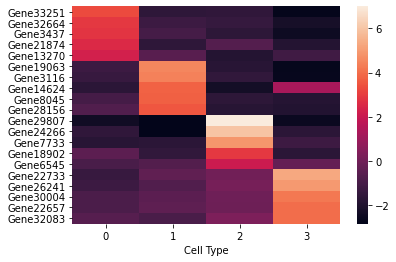

In [20]:
keep_genes = att_df.sort_values(0, ascending=False).head(5).index.tolist()
keep_genes += att_df.sort_values(1, ascending=False).head(5).index.tolist()
keep_genes += att_df.sort_values(2, ascending=False).head(5).index.tolist()
keep_genes += att_df.sort_values(3, ascending=False).head(5).index.tolist()
ax = sns.heatmap(att_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [14]:
att_df.head()

,Gene1,Gene3,Gene5,Gene6,Gene7,Gene10,Gene13,Gene15,Gene16,Gene17,...,Gene33676,Gene33680,Gene33681,Gene33683,Gene33685,Gene33686,Gene33688,Gene33689,Gene33692,Gene33694
0,0.091549,0.110342,0.254197,0.158839,-0.007777,0.025821,0.012084,0.156339,0.024493,0.087815,...,0.006866,0.052088,0.053696,-0.071210,0.025926,0.048481,0.001699,0.078209,-0.011545,0.041869
1,-0.024155,0.020672,-0.229949,0.240513,0.062770,0.250236,-0.037406,0.107607,0.052058,-0.001336,...,-0.010013,0.173700,0.059649,0.020704,0.251783,0.009329,0.022649,-0.058494,0.026689,0.127228
2,-0.015921,0.138411,0.173271,0.101951,-0.045552,0.068225,0.090106,0.397352,-0.061237,-0.035668,...,-0.022034,-0.151399,-0.029236,0.053762,-0.120678,-0.038079,0.026232,0.087235,-0.011987,-0.076107
3,0.001854,-0.293263,0.090203,0.613330,0.033012,0.149187,-0.078745,1.252827,0.043387,0.140687,...,0.089199,0.010187,-0.047533,0.088055,-0.011141,-0.000757,-0.034545,-0.224339,0.060846,-0.067400


In [15]:
int_df.head()

,0,1,2,3
Gene1,0.107672,-0.086372,-0.016295,-0.053542
Gene3,0.050712,-0.166249,0.272642,-0.308062
Gene5,0.129275,-0.590020,0.357630,0.132777
Gene6,-0.065439,-0.149175,0.074644,0.605267
Gene7,-0.020787,0.091659,-0.078057,0.012324


In [68]:
np.std(X[:,2])

2.875029

In [20]:
X.min()

-11.208897

In [16]:
final_preds = preds.max(dim=1)[1].cpu()
zero_class = np.where(final_preds  == 0)[0]
one_class = np.where(final_preds  == 1)[0]
two_class = np.where(final_preds  == 2)[0]
three_class = np.where(final_preds  == 3)[0]

In [17]:
ig = IntegratedGradients(m)
dl = DeepLift(m)
#baseline = torch.FloatTensor(np.zeros((999,500)))
baseline = torch.FloatTensor(np.full((999,500), X.min()))

In [15]:
attributions, delta = dl.attribute(torch.FloatTensor(X).to(model.device), baseline.to(model.device), target=1, return_convergence_delta=True)
#attributions, delta = dl.attribute(torch.FloatTensor(X[zero_class,:]), baseline[zero_class,:], target=0, return_convergence_delta=True)

/Users/daniel/miniconda3/envs/thesis/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/daniel/miniconda3/envs/thesis/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Text(0, 0.5, 'Attribution Score')

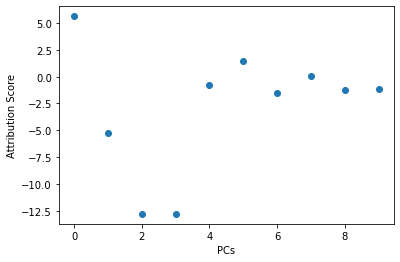

In [13]:
plt.scatter(range(10),torch.mean(attributions, 0).detach()[0:10])
plt.xlabel("PCs")
plt.ylabel("Attribution Score")

In [103]:
attributions, delta = dl.attribute(torch.FloatTensor(X[one_class,:]), baseline[one_class,:], target=1, return_convergence_delta=True)

/Users/daniel/miniconda3/envs/thesis/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/daniel/miniconda3/envs/thesis/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


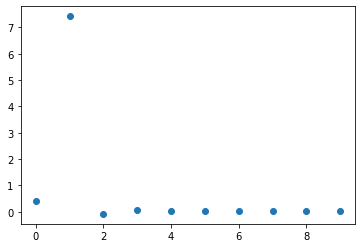

In [104]:
plt.scatter(range(10),torch.mean(attributions, 0).detach()[0:10])

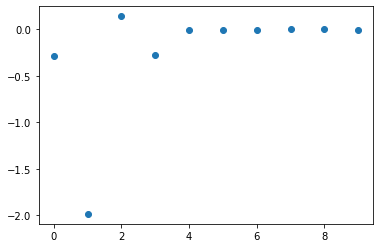

In [84]:
plt.scatter(range(10),torch.mean(attributions[one_class], 0).detach()[0:10])

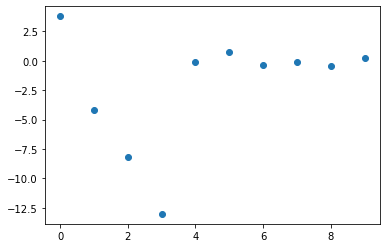

In [60]:
plt.scatter(range(10),torch.mean(attributions[two_class], 0).detach()[0:10])

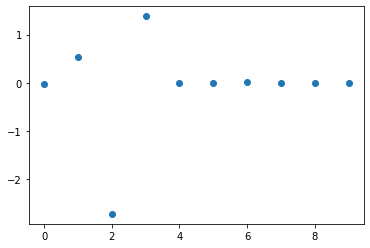

In [52]:
plt.scatter(range(10),torch.mean(attributions[three_class], 0).detach()[0:10])

In [14]:
rpca.components_.shape

(500, 16196)

In [19]:
counts.columns.to_numpy()[keep_genes].shape

(16196,)

In [21]:
gene_loadings = pd.DataFrame(rpca.components_)
gene_loadings.columns = counts.columns.to_numpy()[keep_genes]

In [28]:
gene_loadings.loc[0:10,'Gene33251']

0     0.004840
1    -0.035565
2    -0.113855
3    -0.102661
4    -0.008345
5     0.007263
6    -0.022828
7     0.031805
8    -0.011725
9    -0.024238
10    0.006533
Name: Gene33251, dtype: float32

In [108]:
loadings = rpca.components_.T * np.sqrt(rpca.explained_variance_)
loadings = pd.DataFrame(loadings)
loadings.index = counts.columns.to_numpy()[keep_genes]

In [32]:
loadings.loc["Gene15787", 0:10]

0    -0.309388
1     0.521862
2     0.010022
3     0.009407
4     0.013707
5     0.018611
6     0.043402
7     0.231917
8     0.221386
9     0.075824
10   -0.122973
Name: Gene15787, dtype: float32

In [38]:
markers,marker_names = utilities.read_marker_file(marker_path)
markers = np.array(markers).flatten()

In [109]:
marker_loadings = loadings.loc[markers,0:10]

[Text(0.5, 15.0, 'PCs')]

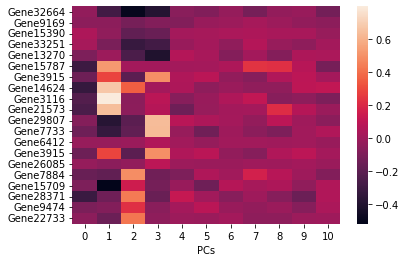

In [133]:
ax = sns.heatmap(marker_loadings)
ax.set(xlabel="PCs")

In [146]:
loadings.sort_values(3, ascending=True).head(70)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Gene2824,-0.030389,-0.134653,-0.431570,-0.482103,-0.077810,0.007452,0.070467,-0.038607,-0.061512,-0.039248,...,0.025529,-0.012375,-0.006256,0.005197,-0.000649,0.010497,0.020930,-0.001483,0.004677,0.000138
Gene3807,-0.259905,0.266721,0.128262,-0.467179,0.154272,0.128886,0.075562,-0.045308,0.231807,0.027786,...,0.000091,0.002283,0.004371,-0.003246,0.002959,-0.006272,-0.005379,0.004767,0.005523,-0.007533
Gene13270,-0.103867,-0.006636,-0.263336,-0.413329,0.065628,0.028404,-0.081050,0.009837,-0.082032,0.040661,...,-0.010611,-0.001757,-0.008131,0.017732,-0.015530,-0.027058,-0.011388,-0.020035,-0.011571,-0.001437
Gene32664,-0.042116,-0.291827,-0.499444,-0.397128,-0.064490,-0.092352,-0.030651,-0.122825,-0.035783,-0.020604,...,0.009920,-0.019484,0.017952,-0.003843,0.011547,0.013118,-0.002215,0.001066,0.002965,-0.001634
Gene7622,-0.168869,0.385449,-0.162479,-0.395037,0.104476,-0.027622,0.068395,0.011744,-0.033714,-0.035294,...,0.014375,0.019073,-0.002713,-0.007774,0.017390,0.019618,0.021789,-0.012914,0.012310,0.005767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene20643,-0.036167,0.027197,-0.003510,-0.088774,0.003864,-0.029087,0.024841,-0.016773,-0.028010,-0.028049,...,-0.010267,-0.015310,0.002371,-0.005969,0.019837,-0.023367,0.007743,0.000808,-0.023577,-0.005140
Gene9169,-0.055109,-0.057626,-0.121381,-0.087011,-0.088591,-0.018188,-0.007271,0.021926,-0.008090,-0.040637,...,-0.007399,0.000587,0.012931,-0.005040,-0.006804,0.001533,-0.008896,0.015401,-0.009113,-0.000836
Gene9748,0.015640,-0.030233,-0.096465,-0.086164,-0.017547,-0.005664,-0.017838,0.009511,-0.002405,0.000323,...,-0.027464,-0.012351,-0.006952,0.012318,-0.007905,-0.018538,0.013956,-0.003171,0.007708,-0.001179
Gene18260,-0.060836,-0.057527,0.041546,-0.083281,-0.038561,-0.007019,0.023524,0.009897,-0.018659,-0.004083,...,-0.002739,0.005561,-0.003191,0.033260,-0.033564,-0.006189,0.009069,0.023487,0.012815,0.032318


In [16]:
# just add other cell attribute scores to atts and final thing will have all
atts = torch.mean(attributions, 0).detach().reshape(-1,1)
#atts = torch.mean(attributions, 0).detach()
cor_loadings = torch.tensor(rpca.components_.T * np.sqrt(rpca.explained_variance_))
gene_att_scores = torch.mm(cor_loadings, atts)

In [17]:
gene_att_scores = gene_att_scores.flatten()
att_df = pd.Series(gene_att_scores)
att_df.index = counts.columns.to_numpy()[keep_genes]

In [18]:
att_df

Gene1       -0.048788
Gene3       -0.232205
Gene5       -0.382508
Gene6       -0.097748
Gene7        0.029013
               ...   
Gene33686    0.013296
Gene33688    0.032047
Gene33689   -0.012375
Gene33692   -0.018728
Gene33694    0.292694
Length: 16196, dtype: float32

In [170]:
att_df.sort_values(ascending=False).iloc[0:50]

Gene33251    7.650831
Gene32664    6.724886
Gene3437     6.579436
Gene2824     5.992122
Gene21874    5.549821
Gene13270    5.483960
Gene15390    4.301842
Gene30144    4.269047
Gene10522    3.916987
Gene5428     3.863543
Gene12062    3.489607
Gene21301    3.141086
Gene1647     2.596230
Gene9169     2.577055
Gene12493    2.375039
Gene9551     2.332636
Gene26322    2.266294
Gene5346     2.196276
Gene7622     2.083753
Gene15163    1.924784
Gene21705    1.907392
Gene14297    1.758702
Gene12114    1.753427
Gene2422     1.753110
Gene27590    1.739917
Gene9748     1.732573
Gene4100     1.685508
Gene32040    1.621864
Gene11391    1.536887
Gene11981    1.461981
Gene14507    1.453266
Gene7848     1.345779
Gene16411    1.312423
Gene23896    1.270719
Gene24532    1.263320
Gene1626     1.238265
Gene1399     1.205447
Gene21191    1.193966
Gene20382    1.168571
Gene1962     1.140689
Gene14896    1.094061
Gene7745     1.088285
Gene18224    1.083453
Gene25351    1.070551
Gene903      1.061026
Gene11548 